### What We're Building (SKIMLIT)

We're building Skimlit, it takes in research data and generates a classification between 5 classes namely `['METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND, 'OBJECTIVE']` to make them easily readable, well skimmed.


**Based from the experimentation notebook and what we got so far.** 
(code first, deep dive later approach)

**Q.** Why use softmax?
> **A.** `softmax` is used for multiclass classification, whereas `sigmoid` is used for binary classification

**Q.** Why did we use only 95% of the percentile to get the `output_seq_len `?
> **A.** (applies to both text and character) Reason being would be, taking the `max` would create unnecessary noise within the tokenizer, whilst using the `95% percentile` would mean, using what's mostly common or should we say relevant.
  
**Q.** Why did we generate a sliced dataset?
> **A.** Similar to our Computer Vision project, we need to set them up as tensors, along with prefetching among the data would make our **training time less than usual, and since we're working with text data, we can't just set a simple train and test set, we should turn everything numerical first and turn them into batches before feeding the data to our machine learning algorithm.**

**Q.** Why can't I set USE to trainable?
> **A.** by our resources aren't enough to let it train, plus we can't selectively enable layers unlike EffNetb0 from our computer vision project.

**Q.** Why did we use Alphabet for creating our character tokenizer?
> **A.** It's because we'll use it as `max tokens` for our character vectorizer

**Q.** Why isn't LSTM working for Character Modelling?
> **A.** The wide amount of combinations of words based from a character would make it hard for our model to learn, from the name itself `LONG SHORT TERM MEMORY`, it takes in previous character but then forgets it after.
 
**IF** we don't get a good enough results from each model(specifically text tokens and character tokens), what we could do is build a hybrid model, where we use both of text and characters as the preprocessing layer then combine/concatenate the weights and biases taken from both models and then filter them towards our output.

**Q.** How do we choose a character model and text model?
> **A.** Through various model experimentations, we can first build a text vectorizer, embedding for the text models and find which among the different models are effective, and then do it again for the characters.

**Q.** Why do we build a different Datasets for both train sentence, and train characters?
> **A.** Again we need to preprocess data before feeding it to our model, it's so we dont encounter any errors, and if we do it's mostly about shapes and our datasets.

In [1]:
### Loading Libraries and Modules
import tensorflow as tf
import pandas as pd
import numpy as np
import json

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from helper_functions import loop_through_files
from helper_functions import create_checkpoint_callback, create_early_stopping_callback, create_reduce_lr_callback, create_tensorboard_callback
from helper_functions import plot_history_curves
from helper_functions import evaluate_model_results, evaluate_text_preds

### Readying up the Data

In [2]:
data_dir = '../../../Datasets/pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [3]:
loop_through_files(data_dir)

['dev.txt', 'outside_text.json', 'outside_text.txt', 'test.txt', 'train.txt']
There are 0 directories and 5 files in '../../../Datasets/pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/'.


#### Preprocessing the Data

In [4]:
def get_lines(filename, data_dir=data_dir):
    #print(data_dir+filename)
    with open(data_dir+filename+'.txt', "r", encoding='utf-8-sig') as f:
        return f.readlines()

In [5]:
test_text = get_lines('test')
train_text = get_lines('train')

We'll need to convert our data into a dictionary.  
From:   
> `['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n', ...] `   

To:  
>`[{'target': 'BACKGROUND',
  'text': 'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  'line_number': 0,
  'total_lines': 8}, ...]`
  
and then feed it to our pandas DataFrame so we can have an easier way of workflow.

In [6]:
def preprocess_text_with_line_numbers(filenames):
    input_lines = get_lines(filenames)
    abstract_lines = ""
    abstract_samples = []
    for line in input_lines:
        if line.startswith('###'):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()
            
            for abstract_line_number, abstact_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstact_line.split("\t")
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower()
                line_data['line_number'] = abstract_line_number
                line_data['total_lines'] = len(abstract_line_split) -1
                abstract_samples.append(line_data)
        else:
            abstract_lines += line
            
    return abstract_samples

In [7]:
train_data = preprocess_text_with_line_numbers('train')
test_data = preprocess_text_with_line_numbers('test')
val_data = preprocess_text_with_line_numbers('dev')

In [8]:
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
val_df = pd.DataFrame(val_data)

In [9]:
len_cat = train_df.target.nunique()

In [10]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

##### Converting our Target variables to Numerical Value

Remember we'd want our data to be of numerical value and of normalized values, specifically from 0 to 1's
this is likely to help our model learn faster and cleaner than having numerical values of different values that has a high range of highs and lows -which could affect training and learning patterns.

In [11]:
# One hot for training
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))

In [12]:
# Label encoder for validation and checking results
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))

C:\Users\gilgamesh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [13]:
#train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
#valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
#test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [14]:
#train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
#valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
#test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#### Building Data for Character Tokens

For character tokens, we'll have to want to split our text data into individual characters/letters.

Q. Why did we use only 95% of the percentile to get the output_seq_len?

> A. (applies to both text and character) Reason being would be, taking the max would create unnecessary noise within the tokenizer, whilst using the 95% percentile would mean, using what's mostly common or should we say relevant.

In [15]:
def split_characters(text):
    return ' '.join(list(text))

In [16]:
train_sentence_char = [split_characters(sentence) for sentence in train_sentences]
test_sentence_char = [split_characters(sentence) for sentence in test_sentences]
val_sentence_char = [split_characters(sentence) for sentence in val_sentences]

In [91]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len # returns 149.3662574983337, but thats not what we want 
output_sequence_length = int(np.percentile(char_lens, 95))
# returns 290

In [18]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [21]:
#train_char_dataset = tf.data.Dataset.from_tensor_slices((train_sentence_char, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
#val_char_dataset = tf.data.Dataset.from_tensor_slices((val_sentence_char, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

#### Building Dataset for our Hybrid Model

What's happening below is we're building a dataset for our hybrid model,
our hybrid model will take in 2 inputs specifically our `train_sentences`, `train_sentence_char` and also our `token_labels` for when our model to train on.

The two inputs are then passed, through our hybrid model and trained.

> **What's happening below is that we're generating datasets to fit on our model, again it takes in two inputs, and then gets their learned weight from the `[LSTM, Bidirectional LSTM]` respectively which is then concatenated afterwards into a single output layer.**

`train_sentences` contains training sentences (text per line)
`train_sentence_char` contains characters split of spaces in between of the sentences
`token_labels` are the one hot encoded values of our targets

In [22]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_sentence_char))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_sentence_char))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_sentence_char))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Building The Vectorizers and Embeddings for our Text and Character Layers

#### Text Vectorizer and Embeddings

In [23]:
max_vocab_length = 65000
max_length = 55

In [24]:
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_vocab_length,
    output_sequence_length=max_length
)

In [25]:
text_vectorizer.adapt(train_sentences)

In [26]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()

In [27]:
embedding = tf.keras.layers.Embedding(
    input_dim=len(rct_20k_text_vocab),
    output_dim=128,
    input_length=max_length,
    embeddings_initializer='uniform'
)

#### Character Tokenizer and Embeddings

In [28]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_sequence_length,
    standardize='lower_and_strip_punctuation',
    name='CHAR_VECTORIZER'
)

char_vectorizer.adapt(train_sentence_char)

In [29]:
char_embed = tf.keras.layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                                       output_dim=25,
                                       mask_zero=False,
                                       name='CHAR_EMBEDDER')

### Building the Hybrid Model

#### Building our input layer 1 of 2
based from our [Experimentation Notebook](https://github.com/jjaimwork/RNN-Natural-Language-Processing/blob/master/Milestone%20Project%20Experimentation.ipynb)   
  
Our `Bidirectional LSTM` Text Modeling Experimentation got the overall best perfomance next to our GRU model,   

` Model              Accuracy    Precision   Recall      F1-Score  
 4_bidirectional	0.789620	0.827468	0.789620	0.805585`
 
 

In [32]:
from tensorflow.keras.layers import LSTM

In [33]:
### Building a Text model with the best resulting model
# Bidirectional LSTM
token_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='token_input')
token_vectorizer = text_vectorizer(token_inputs)
token_embedding = embedding(token_vectorizer)
token_bi_lstm = tf.keras.layers.Bidirectional(LSTM(64))(token_embedding)
token_outputs = tf.keras.layers.Dense(128, activation='softmax', name='output_layer')(token_bi_lstm)
token_model = tf.keras.Model(token_inputs, token_outputs)

#### Building our input layer 1 of 2
based from our [Experimentation Notebook](https://github.com/jjaimwork/RNN-Natural-Language-Processing/blob/master/Milestone%20Project%20Experimentation.ipynb)   
  
Our `LSTM` Text Modeling Experimentation got the overall best perfomance,   

` Model              Accuracy    Precision   Recall      F1-Score  
 10_LSTM	        0.693731    0.699315    0.693731    0.689995`
 
 

In [34]:
### Building a Char model with the best resulting model
# LSTM
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectorize = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectorize)
char_lstm = tf.keras.layers.LSTM(64)(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_lstm)

#### Concatenate the layers

In [35]:
token_char_concat = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

#### Creating the output layer

In [36]:
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(100, activation='relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(len_cat, activation='softmax')(final_dropout)

#### Constructing, Compiling and Fitting the model

In [37]:

model_hybrid = tf.keras.Model(inputs=[token_model.input, char_model.input],
                              outputs=output_layer,
                              name='hybrid_layer')

In [38]:
model_hybrid.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"]
                    )

In [39]:
model_hybrid_history = model_hybrid.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=10,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/10
562/562 [==============================] - 21s 27ms/step - loss: 1.2993 - accuracy: 0.3793 - val_loss: 1.0633 - val_accuracy: 0.4252
Epoch 2/10
562/562 [==============================] - 13s 24ms/step - loss: 1.0632 - accuracy: 0.4534 - val_loss: 0.9071 - val_accuracy: 0.6263
Epoch 3/10
562/562 [==============================] - 14s 24ms/step - loss: 0.8312 - accuracy: 0.6663 - val_loss: 0.6867 - val_accuracy: 0.7294
Epoch 4/10
562/562 [==============================] - 13s 23ms/step - loss: 0.6917 - accuracy: 0.7399 - val_loss: 0.6040 - val_accuracy: 0.7563
Epoch 5/10
562/562 [==============================] - 13s 24ms/step - loss: 0.6549 - accuracy: 0.7620 - val_loss: 0.5579 - val_accuracy: 0.7975
Epoch 6/10
562/562 [==============================] - 13s 24ms/step - loss: 0.6254 - accuracy: 0.7726 - val_loss: 0.5409 - val_accuracy: 0.7969
Epoch 7/10
562/562 [==============================] - 14s 25ms/step - loss: 0.5822 - accuracy: 0.7913 - val_loss: 0.5154 - val_accuracy:

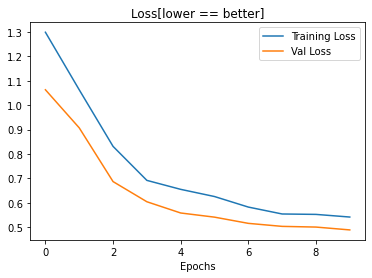

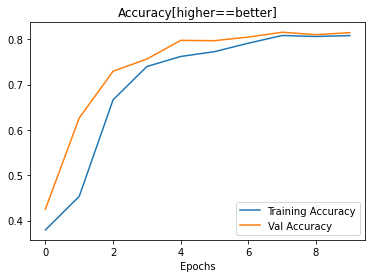

In [40]:
plot_history_curves(model_hybrid_history)

Our model perfomance is working amazingly, our model's validation accuracy and validation loss are even higher than what it's learning. let's evaluate

In [42]:
model_hybrid.evaluate(val_char_token_dataset)

945/945 [==============================] - 8s 9ms/step - loss: 0.4855 - accuracy: 0.8239


[0.48554274439811707, 0.8239441514015198]

In [43]:
model_hybrid_pred_probs = model_hybrid.predict(val_char_token_dataset)
model_hybrid_pred_probs

array([[5.4545009e-01, 2.3010503e-01, 4.7095992e-02, 1.6222239e-01,
        1.5126485e-02],
       [5.4297799e-01, 3.4065801e-01, 1.1835991e-02, 9.9101700e-02,
        5.4263161e-03],
       [3.6407921e-01, 9.1780098e-03, 1.3719691e-02, 6.1174214e-01,
        1.2808975e-03],
       ...,
       [1.2727792e-05, 2.7195008e-03, 1.1412406e-03, 1.1678231e-05,
        9.9611485e-01],
       [1.6910030e-02, 7.6624328e-01, 4.4549080e-03, 4.8422175e-03,
        2.0754951e-01],
       [5.6611795e-02, 9.1151839e-01, 2.4898262e-03, 9.8717231e-03,
        1.9508367e-02]], dtype=float32)

In [44]:
model_hybrid_preds = tf.argmax(model_hybrid_pred_probs, axis=1)
model_hybrid_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [45]:
model_hybrid_results = evaluate_model_results(y_true=val_labels_encoded,
                                    y_preds=model_hybrid_preds)
model_hybrid_results

{'accuracy': 0.8239441281609956,
 'precision': 0.826747292706569,
 'recall': 0.8239441281609956,
 'f1-score': 0.8213882394070038}

Our Model's Evaluation Results are very good, but can we squeeze more of it?

### Fine Tuning our Hybrid Model (Training for Longer)

In [46]:
checkpoint_path = './NLP-NLU-Files/checkpoints/'

In [47]:
earlystopping_callback = create_early_stopping_callback(
    metric='val_accuracy',
    patience=3
)

checkpoint_callback = create_checkpoint_callback(
    checkpoint_path=checkpoint_path,
    metric='val_accuracy',
    save_best=True,
    save_weights=True,
)

lr_callback = create_reduce_lr_callback(
    metric="val_accuracy",
    factor=0.1,
    patience=2,
    verbose=1,
    min_lr=1e-7
)

In [48]:
model_hybrid.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(0.001),
                     metrics=["accuracy"]
                    )

In [49]:
model_hybrid_history_fine_tuned = model_hybrid.fit(
    train_char_token_dataset, # train on dataset of token and characters
    steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
    epochs=100,
    validation_data=val_char_token_dataset,
    validation_steps=int(0.1 * len(val_char_token_dataset)),
    callbacks=[checkpoint_callback, earlystopping_callback]
)

Epoch 1/100
560/562 [============================>.] - ETA: 0s - loss: 0.5304 - accuracy: 0.8151
Epoch 00001: val_accuracy improved from -inf to 0.82380, saving model to ./NLP-NLU-Files/checkpoints\
562/562 [==============================] - 21s 29ms/step - loss: 0.5296 - accuracy: 0.8154 - val_loss: 0.4796 - val_accuracy: 0.8238
Epoch 2/100
560/562 [============================>.] - ETA: 0s - loss: 0.4937 - accuracy: 0.8271
Epoch 00002: val_accuracy did not improve from 0.82380
562/562 [==============================] - 14s 24ms/step - loss: 0.4932 - accuracy: 0.8274 - val_loss: 0.4919 - val_accuracy: 0.8235
Epoch 3/100
560/562 [============================>.] - ETA: 0s - loss: 0.4748 - accuracy: 0.8338
Epoch 00003: val_accuracy improved from 0.82380 to 0.82547, saving model to ./NLP-NLU-Files/checkpoints\
562/562 [==============================] - 15s 26ms/step - loss: 0.4751 - accuracy: 0.8338 - val_loss: 0.4755 - val_accuracy: 0.8255
Epoch 4/100
560/562 [===========================

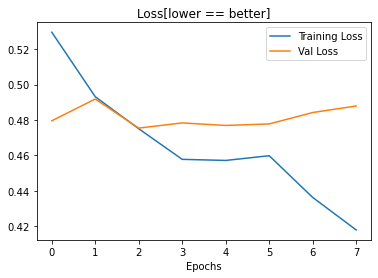

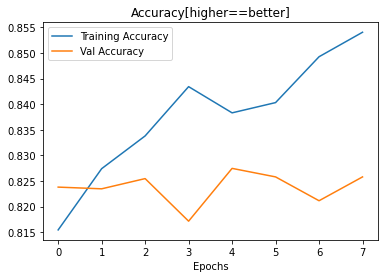

In [50]:
plot_history_curves(model_hybrid_history_fine_tuned)

In [51]:
model_hybrid_preds = tf.argmax(model_hybrid_pred_probs, axis=1)
model_hybrid_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [52]:
model_hybrid_results = evaluate_model_results(y_true=val_labels_encoded,
                                    y_preds=model_hybrid_preds)
model_hybrid_results

{'accuracy': 0.8239441281609956,
 'precision': 0.826747292706569,
 'recall': 0.8239441281609956,
 'f1-score': 0.8213882394070038}

> We only squeezed a bit of performance, reason being would be our model is already `Overfitting` the dataset and
ideally we wouldn't want our model to memorize, let alone just be of a perfect model for our training set...
reason being would be our model would use its `MEMORIZED WEIGHTS`, not its `LEARNED WEIGHTS`. We'd want it to perform well on the validation set and test set rather than a perfect fit for training set.

### Predicting on our Test Dataset

In [53]:
test_pred_probs = model_hybrid.predict(test_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 8s 8ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 2, 2, 2, 4, 4, 4, 0, 1, 0], dtype=int64)>

In [54]:
hybrid_test_results = evaluate_model_results(test_preds, test_labels_encoded)
hybrid_test_results

{'accuracy': 0.8189148830263813,
 'precision': 0.8199137393108852,
 'recall': 0.8189148830263813,
 'f1-score': 0.8166574418469296}

In [55]:
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes[:5]

['BACKGROUND', 'METHODS', 'METHODS', 'METHODS', 'RESULTS']

In [56]:
test_df['prediction'] = test_pred_classes
test_df['pred_prob'] = tf.reduce_max(test_pred_probs, axis=1)
test_df['correct'] = test_df['prediction'] == test_df['target']

In [57]:
test_df.columns

Index(['target', 'text', 'line_number', 'total_lines', 'prediction',
       'pred_prob', 'correct'],
      dtype='object')

In [58]:
test_df = test_df[['text', 'line_number', 'total_lines', 'target', 'prediction',
       'pred_prob', 'correct']]

In [104]:
test_df[:5]

,text,line_number,total_lines,target,prediction,pred_prob,correct
0,this study analyzed liver function abnormaliti...,0,8,BACKGROUND,BACKGROUND,0.533228,True
1,a post hoc analysis was conducted with the use...,1,8,RESULTS,METHODS,0.976199,False
2,liver function tests ( lfts ) were measured at...,2,8,RESULTS,METHODS,0.971685,False
3,survival analyses were used to assess the asso...,3,8,RESULTS,METHODS,0.975006,False
4,the percentage of patients with abnormal lfts ...,4,8,RESULTS,RESULTS,0.984282,True


In [109]:
most_right = test_df[test_df['correct']==True].sort_values(by='pred_prob', ascending=False)
most_right.iloc[5].text

'both tafluprost and travoprost significantly increased the @-h mopp ( p = @ , p = @ , respectively ) , and travoprost demonstrated a greater @-h mopp than tafluprost ( p = @ ) .'

In [119]:
for i in range(9,15):
    print(f'\nPrediction: {test_df.iloc[i].prediction} | Target:{test_df.iloc[i].target}\n', test_df.iloc[i].text)


Prediction: BACKGROUND | Target:BACKGROUND
 minimally invasive endovascular aneurysm repair ( evar ) could be a surgical technique that improves outcome of patients with ruptured abdominal aortic aneurysm ( raaa ) .

Prediction: OBJECTIVE | Target:BACKGROUND
 the aim of this study was to analyse the cost-effectiveness and cost-utility of evar compared with standard open repair ( or ) in the treatment of raaa , with costs per @-day and @-month survivor as outcome parameters .

Prediction: METHODS | Target:METHODS
 resource use was determined from the amsterdam acute aneurysm ( ajax ) trial , a multicentre randomized trial comparing evar with or in patients with raaa .

Prediction: METHODS | Target:METHODS
 the analysis was performed from a provider perspective .

Prediction: METHODS | Target:METHODS
 all costs were calculated as if all patients had been treated in the same hospital ( onze lieve vrouwe gasthuis , teaching hospital ) .

Prediction: RESULTS | Target:RESULTS
 a total of @ 

In [60]:
most_wrong = test_df[test_df['correct']==False].sort_values(by='pred_prob', ascending=False)

In [61]:
most_wrong[:5]

,text,line_number,total_lines,target,prediction,pred_prob,correct
13598,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,METHODS,RESULTS,0.997219,False
12158,"in the saffron group , there was no decline in...",9,12,METHODS,RESULTS,0.996770,False
25664,rifampicin significantly increased the mean ar...,6,11,CONCLUSIONS,RESULTS,0.996737,False
27952,"sr-wbv with @hz , noise level @ shows benefit ...",12,13,CONCLUSIONS,RESULTS,0.996327,False
21186,mean distraction rates were similar between gr...,8,17,METHODS,RESULTS,0.996258,False


### Predicting Outside our Dataset

Text Taken from [mrdbourke raw](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json)

In [62]:
outside_text = '../../../Datasets/pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/outside_text.json'

In [63]:
with open(outside_text, "r") as f:
  example_abstracts = json.load(f)

In [64]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [65]:
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe('sentencizer') # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [66]:
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)

In [67]:
sample_df = pd.DataFrame(sample_lines)
sample_df

,text,line_number,total_lines
0,This RCT examined the efficacy of a manualized...,0,7
1,Participants were randomly assigned to treatme...,1,7
2,Treatment included instruction and therapeutic...,2,7
3,A response-cost program was applied to reduce ...,3,7
4,Significant treatment effects were found for f...,4,7
5,Secondary measures based on staff ratings (tre...,5,7
6,"High levels of parent, child and staff satisfa...",6,7
7,Standardized effect size estimates were primar...,7,7


In [68]:
sample_sentences = sample_df['text'].to_list()

In [69]:
sample_data_line_numbers = [line["line_number"] for line in sample_lines]
sample_data_line_numbers_one_hot = tf.one_hot(sample_data_line_numbers, depth=5) 
sample_data_line_numbers_one_hot

<tf.Tensor: shape=(8, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

In [70]:
sample_dataset = tf.data.Dataset.from_tensor_slices((sample_sentences, sample_data_line_numbers_one_hot))

In [71]:
sample_dataset = sample_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [74]:
sample_data_line_numbers = [line["line_number"] for line in sample_lines]
sample_data_line_numbers_one_hot = tf.one_hot(sample_data_line_numbers, depth=5) 
sample_data_line_numbers_one_hot

<tf.Tensor: shape=(8, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

In [76]:
sample_sentence_char = [split_characters(sentence) for sentence in sample_sentences]

In [78]:
sample_char_token_data = tf.data.Dataset.from_tensor_slices((sample_sentences, sample_sentence_char))
sample_char_token_labels = tf.data.Dataset.from_tensor_slices(sample_data_line_numbers_one_hot)
sample_char_token_dataset = tf.data.Dataset.zip((sample_char_token_data, sample_char_token_labels))

sample_char_token_dataset = sample_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [79]:
sample_abstract_pred_probs = model_hybrid.predict(x=sample_char_token_dataset)

In [81]:
sample_abstract_preds = tf.argmax(sample_abstract_pred_probs, axis=1)
sample_abstract_preds[:10]

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 2, 2, 2, 4, 2, 4, 4], dtype=int64)>

In [82]:
sample_abstract_pred_classes = [label_encoder.classes_[pred] for pred in sample_abstract_preds]

In [83]:
sample_df['prediction'] = sample_abstract_pred_classes

In [85]:
sample_df

,text,line_number,total_lines,prediction
0,This RCT examined the efficacy of a manualized...,0,7,BACKGROUND
1,Participants were randomly assigned to treatme...,1,7,METHODS
2,Treatment included instruction and therapeutic...,2,7,METHODS
3,A response-cost program was applied to reduce ...,3,7,METHODS
4,Significant treatment effects were found for f...,4,7,RESULTS
5,Secondary measures based on staff ratings (tre...,5,7,METHODS
6,"High levels of parent, child and staff satisfa...",6,7,RESULTS
7,Standardized effect size estimates were primar...,7,7,RESULTS


In [84]:
for i in range(0,7):
    print(f"{sample_df['prediction'][i]} \n{sample_df['text'][i]}\n")

BACKGROUND 
This RCT examined the efficacy of a manualized social intervention for children with HFASDs.

METHODS 
Participants were randomly assigned to treatment or wait-list conditions.

METHODS 
Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.

METHODS 
A response-cost program was applied to reduce problem behaviors and foster skills acquisition.

RESULTS 
Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).

METHODS 
Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.

RESULTS 
High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.

